In [10]:
from __future__ import division
import numpy as np  
import os  
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import matplotlib.pyplot as plt 
os.environ['TF_CPP_MIN_LOG_LEVEL']='2' 
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

import matplotlib.gridspec as gridspec
tf.device('/gpu:0')
mnist = input_data.read_data_sets('MNIST_data')
#
#data=np.load('data.npy')
#label=np.load('label.npy')


Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [0]:
tf.reset_default_graph()
batch_size = 100
g_dim = 128
x_d = tf.placeholder(tf.float32, shape = [None, 784])
x_g = tf.placeholder(tf.float32, shape = [None, g_dim])
weights = {
    "w_e1" : tf.Variable(tf.random_normal([784,250],stddev=0.2)),
    "w_e2" : tf.Variable(tf.random_normal([250,g_dim],stddev=0.2)),
    
    "w_d1" : tf.Variable(tf.random_normal([g_dim, 250],stddev=0.2)),
    "w_d2" : tf.Variable(tf.random_normal([250,784],stddev=0.2)),
    
    
    "w_dis1" : tf.Variable(tf.random_normal([g_dim, 20],stddev=0.2)),
    "w_dis2" : tf.Variable(tf.random_normal([20, 1],stddev=0.2)),
                }

biases = {
    "b_e1" : tf.Variable(tf.random_normal([250],stddev=0.2)),
    "b_e2" : tf.Variable(tf.random_normal([g_dim],stddev=0.2)),
    "b_d1" : tf.Variable(tf.random_normal([250],stddev=0.2)),
    "b_d2" : tf.Variable(tf.random_normal([784],stddev=0.2)),
    "b_dis1" : tf.Variable(tf.random_normal([20],stddev=0.2)),
    "b_dis2" : tf.Variable(tf.random_normal([1],stddev=0.2)),
    
    
            }

In [0]:
def encoder(x):    #None*784
    h_e1=tf.nn.relu(tf.add(tf.matmul(x,weights['w_e1']),biases['b_e1']))
    h_e2=tf.nn.sigmoid(tf.add(tf.matmul(h_e1,weights['w_e2']),biases['b_e2']))
    return h_e2 #None*100
def decoder(x):   #None*100
    h_d1=tf.nn.relu(tf.add(tf.matmul(x,weights['w_d1']),biases['b_d1']))
    h_d2=tf.nn.sigmoid(tf.add(tf.matmul(h_d1,weights['w_d2']),biases['b_d2']))
    return h_d2  #None*784
def discriminator(x):  #None*100
    h_dis1  =tf.nn.tanh(tf.add(tf.matmul(x, weights['w_dis1']), biases['b_dis1']))
    h_dis2  =tf.nn.sigmoid(tf.add(tf.matmul(h_dis1, weights['w_dis2']), biases['b_dis2']))
    return h_dis2  #None*1

def sample_Z(m, n):
    return np.random.normal(0,1, size=[m, n])    
    

In [0]:
latent=encoder(x_d)
x_recon=decoder(latent)
x_true=discriminator(latent)
x_fake=discriminator(x_g)




r_loss=tf.sqrt(tf.reduce_sum(tf.pow(x_recon-x_d,2)))



d_loss=-tf.reduce_mean(tf.log(x_fake+1e-8))- tf.reduce_mean(tf.log(1. -x_true+1e-8))
g_loss=-tf.reduce_mean(tf.log(x_true+1e-8))

d_optimizer = tf.train.RMSPropOptimizer(0.0001).minimize(d_loss)
g_optimizer = tf.train.RMSPropOptimizer(0.0001).minimize(g_loss)
r_optimizer = tf.train.RMSPropOptimizer(0.0001).minimize(r_loss)

In [39]:
gpu_opt=tf.GPUOptions(per_process_gpu_memory_fraction=0.8)
config=tf.ConfigProto(log_device_placement=True,gpu_options=gpu_opt)
sess = tf.InteractiveSession(config=config)
init_op = tf.global_variables_initializer()
sess.run(init_op)
error_r=[]
error_g=[]
error_d=[]

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0



/tensorflow-1.15.0/python3.6/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [40]:
for step in range(500):
    tmp_r=[]
    tmp_g=[]
    tmp_d=[]
    for i in range(int(2000/batch_size)):
        batch_x ,_= mnist.train.next_batch(batch_size,shuffle=True)
        _,r_loss_train =sess.run([r_optimizer, r_loss],\
                                  feed_dict = {x_d:batch_x})
        _, d_loss_train = sess.run([d_optimizer, d_loss],\
                                   feed_dict = {x_d: batch_x,x_g:sample_Z(batch_size,g_dim)})
        _,g_loss_train = sess.run([g_optimizer,g_loss], \
                                  feed_dict = {x_d:batch_x})
        tmp_r.append(r_loss_train)
        tmp_g.append(d_loss_train)
        tmp_d.append(g_loss_train)
    if step%10 ==0:
        print("step %d, discriminator loss %.5f" % (step, d_loss_train)),
        print(" generator loss %.5f" % g_loss_train),
        print ("recontruction loss %.5f" %r_loss_train)
        print ('fake',x_fake.eval(feed_dict = {x_d:batch_x,x_g: sample_Z(batch_size, g_dim)})[0] )
        print ('origin',x_true.eval(feed_dict = {x_d:batch_x,x_g: sample_Z(batch_size, g_dim)})[0])
    
    error_r.append(np.mean(tmp_r))
    error_g.append(np.mean(tmp_g))
    error_d.append(np.mean(tmp_d))
x_reconstruct=x_recon.eval(feed_dict = {x_d:mnist.train.images})
latent_vector = latent.eval(feed_dict = {x_d:mnist.train.images})

step 0, discriminator loss 1.19176
 generator loss 1.02207
recontruction loss 174.36209
fake [0.51710033]
origin [0.35694665]
step 10, discriminator loss 1.30672
 generator loss 0.85675
recontruction loss 99.27692
fake [0.43192604]
origin [0.41284242]
step 20, discriminator loss 1.24462
 generator loss 0.79476
recontruction loss 72.01508
fake [0.61669296]
origin [0.48977733]
step 30, discriminator loss 1.35026
 generator loss 0.74305
recontruction loss 66.51128
fake [0.52844244]
origin [0.42830867]
step 40, discriminator loss 1.28505
 generator loss 0.72043
recontruction loss 64.77906
fake [0.541119]
origin [0.512987]
step 50, discriminator loss 1.33910
 generator loss 0.70292
recontruction loss 59.83195
fake [0.46917337]
origin [0.58112824]
step 60, discriminator loss 1.36361
 generator loss 0.67559
recontruction loss 56.20750
fake [0.5899029]
origin [0.54078496]
step 70, discriminator loss 1.38997
 generator loss 0.65629
recontruction loss 55.59811
fake [0.4135834]
origin [0.53153604

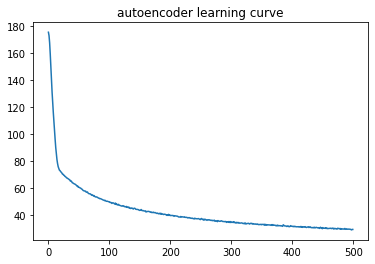

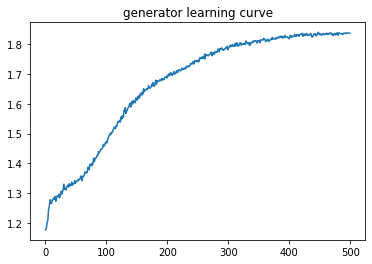

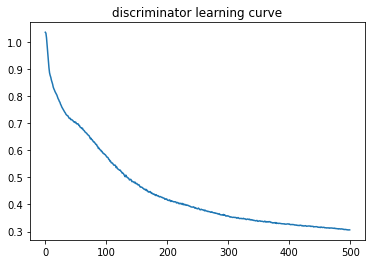

In [41]:
plt.plot(range(500),error_r,label='learning_r')
plt.title("autoencoder learning curve")
plt.show()
plt.plot(range(500),error_g,label='learning_g')
plt.title("generator learning curve")
plt.show()
plt.plot(range(500),error_d,label='learning_d')
plt.title("discriminator learning curve")
plt.show()


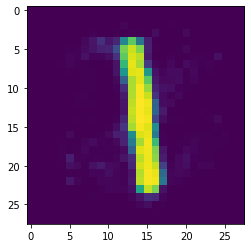

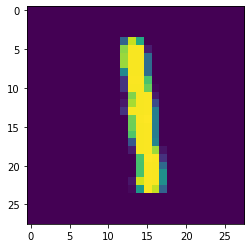

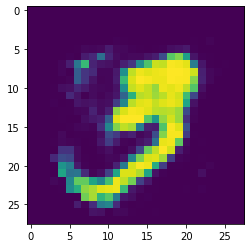

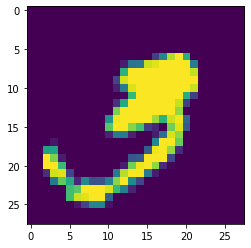

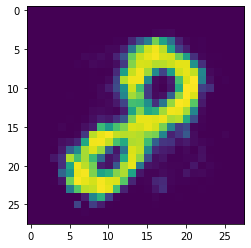

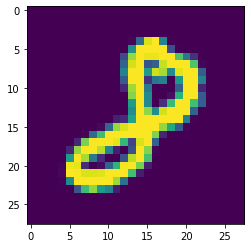

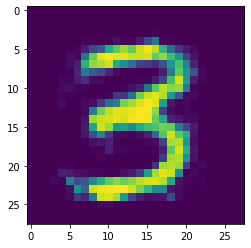

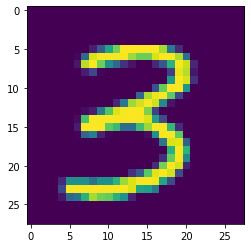

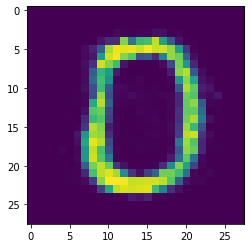

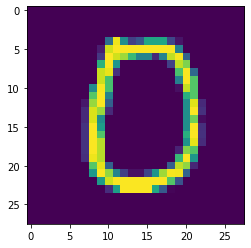

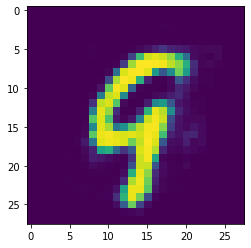

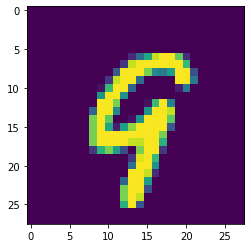

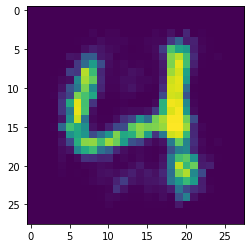

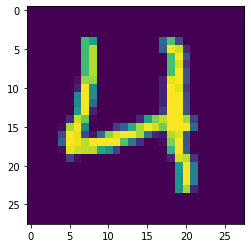

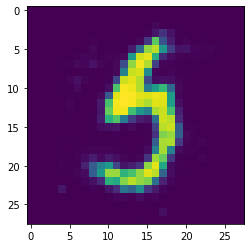

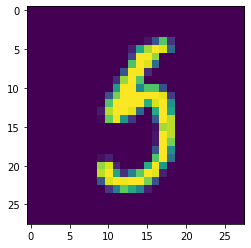

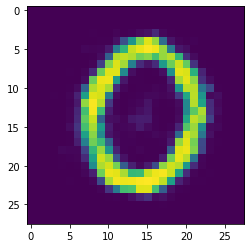

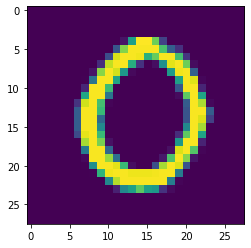

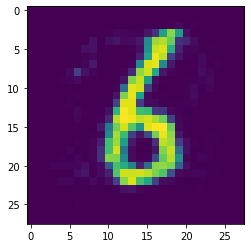

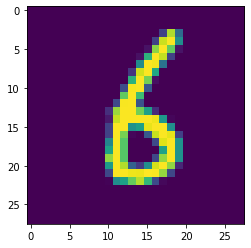

In [42]:

randomize = np.arange(mnist.train.images.shape[0])
np.random.shuffle(randomize)
for i in randomize[:10]:
    fig=plt.figure()
    plt.imshow(x_reconstruct[i].reshape(28,28))
    plt.show()
    fig=plt.figure()
    plt.imshow(mnist.train.images[i].reshape(28,28))
plt.show()



In [0]:
from sklearn.manifold import TSNE
import matplotlib.cm as cm
'''
z is the output of encoder
z = model.encoding(sess, data)
'''
tsne = TSNE(n_components = 2, random_state = 0)
t_z = tsne.fit_transform(latent_vector)

'''
plot the t_z, color is determined by label
'''
colors = cm.rainbow(np.linspace(0, 1, 10))
scatter1 = []
index = xrange(10)
for i in range(10):
    tmp = np.where(label == i)
    scatter1.append(plt.scatter(t_z[tmp, 0], t_z[tmp, 1], c=colors[i],s=5 ))

plt.legend(scatter1, index)
plt.show()

    